# Random Forest Model for Movie Score Prediction

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint, uniform


## Load Datasets
Both training and test datasets are loaded.
The test dataset is only used for evaluating the baseline random forest model, the final model is evaluated in the testing notebook.


In [17]:
trainingDatasetPath = os.path.join('..','..', 'data', 'training_dataset.csv')
dataset_training = pd.read_csv(trainingDatasetPath, sep=';')

In [18]:
testDatasetPath = os.path.join('..','..', 'data', 'test_dataset.csv')
df_test = pd.read_csv(testDatasetPath, sep=";")

## Preparing the Data
The training and test datasets are prepared for the random forest model.

In [19]:
y_train = dataset_training['movie_score'].values
dataset_training = dataset_training.drop(columns=['movie_score', 'Unnamed: 0', 'averageRating', 'numVotes', '_orig_order'])
x_train = dataset_training.values


In [20]:
y_test = df_test['movie_score'].values
df_test = df_test.drop(columns=['movie_score', 'Unnamed: 0', 'averageRating', 'numVotes', '_orig_order'])
x_test = df_test.values


## Create and Train Basic Random Forest Model
Here a basic random forest model is trained, without any hyperparameter tuning. This will act as a baseline for the performance of the optimized model.

In [21]:
# Creating and training a basic random forest model
rf_basic = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_basic.fit(x_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# Evaluate basic model
y_train_pred = rf_basic.predict(x_train)
y_test_pred = rf_basic.predict(x_test)

print("Basic Random Forest Model Performance:")
print(f"Training R²: {r2_score(y_train, y_train_pred):.3f}")
print(f"Test R²: {r2_score(y_test, y_test_pred):.3f}")
print(f"Training RMSE: {np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred))):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_test_pred))):.3f}")
print(f"Training MAE: {mean_absolute_error(np.expm1(y_train), np.expm1(y_train_pred)):.3f}")
print(f"Test MAE: {mean_absolute_error(np.expm1(y_test), np.expm1(y_test_pred)):.3f}")


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.6s


Basic Random Forest Model Performance:
Training R²: 0.945
Test R²: 0.479
Training RMSE: 23517.091
Test RMSE: 17315.365
Training MAE: 1931.087
Test MAE: 2160.191


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.2s finished


## Hyperparameter Tuning with RandomizedSearchCV


In [25]:
# Random Forest with RandomizedSearchCV (much faster than GridSearchCV)
rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_samples=0.8, verbose=0)

# Optimized parameter distributions for faster search
param_dist_rf = {
    # n_estimators: Number of decision trees in the random forest ensemble.
    # More trees generally improve performance but increase training time.
    # Values: 300 or 400 trees
    'n_estimators': [300, 400],
    
    # max_depth: Maximum depth of each decision tree in the forest.
    # Deeper trees can capture more complex patterns but may overfit.
    # None means nodes are expanded until all leaves are pure or contain min_samples_split samples.
    # Values: 10, 20, 30, or 40 levels deep
    'max_depth': [10, 20, 30, 40],
    
    # min_samples_split: Minimum number of samples required to split an internal node.
    # Higher values prevent overfitting by requiring more samples before splitting.
    # Random integer between 2 and 20 (exclusive of 20)
    'min_samples_split': randint(2, 20),
    
    # min_samples_leaf: Minimum number of samples required to be at a leaf node.
    # Higher values create more conservative trees and reduce overfitting.
    # Random integer between 2 and 15 (exclusive of 15)
    'min_samples_leaf': randint(2, 15),
    
    # max_features: Number of features to consider when looking for the best split.
    # 'sqrt': Uses sqrt(n_features) features (common default for classification)
    # 'log2': Uses log2(n_features) features (another common choice)
    # This parameter controls the randomness and diversity of trees in the ensemble.
    'max_features': ['sqrt', 'log2']
}
cv = TimeSeriesSplit(n_splits=5)

rf_random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=30, 
    cv=cv,
    scoring='r2',
    n_jobs=1,
    verbose=2,
    random_state=42
)
rf_random_search.fit(x_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=30, max_features=log2, min_samples_leaf=14, min_samples_split=16, n_estimators=300; total time=   4.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=14, min_samples_split=16, n_estimators=300; total time=   8.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=14, min_samples_split=16, n_estimators=300; total time=  13.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=14, min_samples_split=16, n_estimators=300; total time=  16.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=14, min_samples_split=16, n_estimators=300; total time=  20.4s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=400; total time=   8.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=400; total time=  19.2s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_est

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': <scipy.stats....t 0x11b419d90>, 'min_samples_split': <scipy.stats....t 0x11abbda70>, ...}"
,n_iter,30
,scoring,'r2'
,n_jobs,1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [27]:
best_model = rf_random_search.best_estimator_

# Refit best model on ALL data
best_model.fit(x_train, y_train)
# Save the model
joblib.dump(best_model, "../random_forest_reg_movie_log_transformed.joblib")

# Saves the best parameters and tried parameters to csv file
cv_results = pd.DataFrame(rf_random_search.cv_results_)
saveRandomForestRegressorCvResultsAt = os.path.join('..','..', 'data', 'random_forest_reg_movie_log_transformed.csv')
cv_results.to_csv(saveRandomForestRegressorCvResultsAt, index=False)

In [28]:
# Inspect best Random Forest parameters and scores
best_params_rf = rf_random_search.best_params_
best_rf = rf_random_search.best_estimator_

print(f"Best Random Forest parameters: {best_params_rf}")
print(f"Best Random Forest CV R-squared: {rf_random_search.best_score_:.3f}")
print(f"Best Random Forest training R-squared: {best_rf.score(x_train, y_train):.3f}")
print(f"Best Random Forest test R-squared: {best_rf.score(x_test, y_test):.3f}")

# Additional metrics
y_train_pred_best = best_rf.predict(x_train)
y_test_pred_best = best_rf.predict(x_test)

print(f"\nBest Random Forest Model Performance:")
print(f"Training RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_best)):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_best)):.3f}")
print(f"Training MAE: {mean_absolute_error(y_train, y_train_pred_best):.3f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred_best):.3f}")
#Best Random Forest parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 400}


Best Random Forest parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 400}
Best Random Forest CV R-squared: 0.570
Best Random Forest training R-squared: 0.839
Best Random Forest test R-squared: 0.492

Best Random Forest Model Performance:
Training RMSE: 0.835
Test RMSE: 1.469
Training MAE: 0.627
Test MAE: 1.159


## Feature Importance Analysis


In [29]:
# Get feature importances from the best model
feature_importances = best_rf.feature_importances_
feature_names = dataset_training.columns

# Create a DataFrame for easier visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Display top 20 most important features
print("Top 20 Most Important Features:")
print(importance_df.head(20))


Top 20 Most Important Features:
                           feature  importance
4           prior1_rating_director    0.118331
8       actor1_prior2_rating_actor    0.061118
5           prior2_rating_director    0.059245
9       actor1_prior3_rating_actor    0.057822
7       actor1_prior1_rating_actor    0.052243
6           prior3_rating_director    0.041438
11      actor2_prior1_rating_actor    0.037024
12      actor2_prior2_rating_actor    0.035494
13      actor2_prior3_rating_actor    0.028491
15      actor3_prior1_rating_actor    0.027585
2                   runtimeMinutes    0.024477
16      actor3_prior2_rating_actor    0.021853
17      actor3_prior3_rating_actor    0.019320
23      actor5_prior1_rating_actor    0.018263
19      actor4_prior1_rating_actor    0.018126
3   prior_movie_director_sentiment    0.017447
27      actor6_prior1_rating_actor    0.015241
1                        startYear    0.014156
47             years_since_release    0.014083
48     years_since_release_s

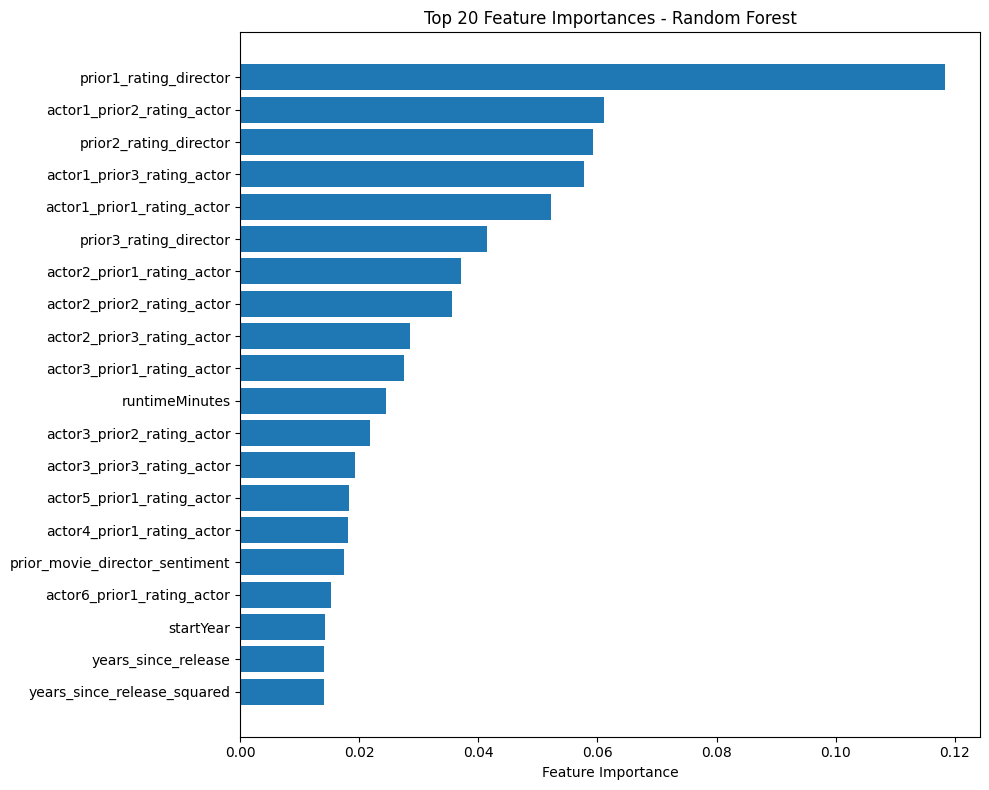

In [30]:
# Visualize top 20 feature importances
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Cross-Validation Score


In [ ]:
# Perform cross-validation on the best model
cv_scores = cross_val_score(best_rf, x_train, y_train, cv=10, scoring='r2', n_jobs=-1)
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Cross-validation R² scores: [0.52733395 0.58078791 0.55364327 0.58916887 0.62133858 0.60205397
 0.61308797 0.59568493 0.59248095 0.55518221]
Mean CV R²: 0.583 (+/- 0.056)
